This is a continuation of score predictor part 1, focusing on the second innings of a match and the liklihood of a team winning.

## 7. Match Predictions

In this section I will create a model which will give match predictions based on an in-progress second innings. Essentially this involves determining whether the predicted score of the team batting second is greater than the actual score of the team batting first. The probability of winning or losing will be determined by the confidence intervals around the predicted score.

This can be seen visually in the graph in sub section 6.3. If the team batting first has a score which lies 25 runs below the predicted score of the team batting second in the 40th over then the second team has about an 84% chance of winning. This is because the score of the team batting first lies approximately on the lower confidence interval, which is set at 1 standard deviation. The confidence interval contains around 68% of the results, with 16% lying below and 16% above. Only results which lie below result in a loss, so the team batting second has a 84% chance of winning.


In [4]:
## import basic libraries

%matplotlib inline
import matplotlib

#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pickle

sns.set(style="darkgrid")

In [9]:
stats = pickle.load(open("stats_for_predictions.pkl",'rb'))
match_information = pd.read_csv(r'processed_data/match_information.csv')

#use data from only the first innings
data = stats.loc[stats['innings'] == 1]
data = data[:]

#split into training and testing data
np.random.seed(42)

test_size = 0.25
matches = data.match_id.unique()
number_of_matches = data.match_id.unique().shape[0]
test_matches = np.random.choice(matches, size = np.int(np.floor(number_of_matches * test_size)), replace=False)
train_matches = np.setdiff1d(matches, test_matches)

features = data[['over','wickets','cum_score','strike_runs','offstrike_runs']]

match_scores = data[['match_id','score']].groupby('match_id').agg('first')
match_scores.reset_index(inplace=True)

data_train = data.loc[data['match_id'].isin(train_matches)]
data_test = data.loc[data['match_id'].isin(test_matches)]

X_train_ = data_train[['over','wickets','cum_score','strike_runs','offstrike_runs']]
y_train = data_train[['score']]
y_train_r = data_train[['rrate']]


X_test_ = data_test[['over','wickets','cum_score','strike_runs','offstrike_runs']]
y_test = data_test[['score']]
y_test_r = data_test[['rrate']]


#apply a standard scaler to the features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train_.to_numpy())
X_test = sc.transform(X_test_.to_numpy())

X_full = features[:]
y_full = data[['score']]
y_full_r = data[['rrate']]

### 7.1 Predictions on second innings

Fit match score predictions on matches in the second innings.

In [10]:
#fit infered score predictions using runrate on rolling window of the dataset

from sklearn.linear_model import LinearRegression


data = stats.loc[stats['innings'] == 1]
FirstInningsPredictions = data[['match_id','over','score','wickets','cum_score']]
FirstInningsPredictions = FirstInningsPredictions[:]

data = stats.loc[stats['innings'] == 2]
SecondInningsPredictions = data[['match_id','over','score','wickets','cum_score']]
SecondInningsPredictions = SecondInningsPredictions[:]

#set training data for second innings
features = data[['over','wickets','cum_score','strike_runs','offstrike_runs']]
X_full_2 = features[:]
y_full_2 = data[['score']]
y_full_r_2 = data[['rrate']]




# fit over by over with a window of N overs
N = 2


#X_full
#y_full

for over_number in data.over.unique():

    
    #predictions on score
        #train on a window around over_number
    X_train_o_ = X_full.loc[np.abs(X_full.over - over_number) <= N]
    X_train_o = sc.fit_transform(X_train_o_.to_numpy())
        #test on over number
    X_test_o_ = X_full.loc[X_full.over == over_number]
    X_test_o = sc.fit_transform(X_test_o_.to_numpy())
    
    y_train_ro = y_full_r[np.abs(X_full.over - over_number) <= N]
    y_train_ro = y_train_ro.to_numpy().ravel()
    
#     X_train_o_2_ = X_full_2.loc[np.abs(X_full.over - over_number) <= N]
#     X_train_o_2 = sc.fit_transform(X_train_o_2_.to_numpy())
    
    X_test_o_2_ = X_full_2.loc[X_full_2.over == over_number]
    X_test_o_2 = sc.fit_transform(X_test_o_2_.to_numpy())
    
#     y_train_ro_2 = y_full_r_2[np.abs(X_full_2.over - over_number) <= N]
#     y_train_ro_2 = y_train_ro_2.to_numpy().ravel()


        
    lin = LinearRegression()
    lin.fit(X_train_o,y_train_ro)
    #update values
    #predict first innings scores
    FirstInningsPredictions.loc[(FirstInningsPredictions.over)==over_number, 'pred_r'] = lin.predict(X_test_o)
    #predict second innings scores
    SecondInningsPredictions.loc[(SecondInningsPredictions.over) == over_number, 'pred_r'] = lin.predict(X_test_o_2)
    

#fit predictions for first innings of matches
FirstInningsPredictions['pred_score_r'] = FirstInningsPredictions['pred_r'] *(50 - FirstInningsPredictions.over) + FirstInningsPredictions.cum_score
FirstInningsPredictions['error_r'] = FirstInningsPredictions['pred_score_r'] - FirstInningsPredictions['score']

mean_rr = data[['match_id','score']].groupby(['match_id']).first().mean() / 50
FirstInningsPredictions['error_mean_r'] =  mean_rr[0] * (50-FirstInningsPredictions.over) + FirstInningsPredictions.cum_score - FirstInningsPredictions.score


#fit predictions for second innings of matches
    #note that finding error is meaningless in second innings since matches are cut short if the score exceeds 
    #the first innings score. For this reason only the predicted score is calculated.
SecondInningsPredictions['pred_score_r'] = SecondInningsPredictions['pred_r'] *(50 - SecondInningsPredictions.over) + SecondInningsPredictions.cum_score


## append target score (ie the first inning score) to SecondInningsPredictions
targets = FirstInningsPredictions[['match_id','score']]
targets = targets[:]
targets.drop_duplicates(subset='match_id', inplace=True)
targets.rename(columns={'score':'target_score'}, inplace=True)
winner_bool = stats[['match_id','winner_bool']].groupby('match_id').agg({'winner_bool':'first'}).reset_index()
winner_bool.rename(columns={'winner_bool':'2nd_team_win'},inplace=True)
    #since winner_bool is for the first team, need to negate this
winner_bool['2nd_team_win'] = np.invert(winner_bool[['2nd_team_win']])

SecondInningsPredictions = pd.merge(SecondInningsPredictions, targets, how='left', on='match_id')
SecondInningsPredictions = pd.merge(SecondInningsPredictions, winner_bool, how='left', on=['match_id'])



In [11]:
#loads precalculated SecondInningsPredictions 
    #recalculating can be time consuming
load_precalculated = True


grouped_errors = pd.DataFrame([])

#from FirstInningsPredictions create a list of all error_r for each over and save to a new DF 
for over in FirstInningsPredictions.over.unique():
    x = (FirstInningsPredictions.loc[FirstInningsPredictions['over'] == over]['error_r'])
    grouped_errors[over] = [x.values]

#now to get values from over 0.5 use # grouped_errors[0.5][0]
#can then perform operations on the resulting array like # .std()
def win_pct(grouped_errors, score_diff, over):
    """
    Takes a distribution of differences between predicted scores and actual scores.
    This distribution is then compared to the difference in predicted score for a second
    team against their target score to determine the confidence of the second team winning.
    """
    num_scores_above = np.sum(grouped_errors[over][0] > score_diff)
    total_scores = len(grouped_errors[over][0])
    win_percentage = 100 * num_scores_above / total_scores
    
    return win_percentage

if load_precalculated == True:
    
    SecondInningsPredictions = pickle.load(open("SecondInningsPredictions.pkl",'rb'))
    print('finished precalc loading')
else:
#calculate the chance of the second team winning for every ball in every match
    #this process is not optimised and is time consuming
    #approx 300 000 indices as of 2019
    SecondInningsPredictions['win_chance_pct'] = 0
    for x in SecondInningsPredictions.index:
        SecondInningsPredictions.loc[x,'win_chance_pct'] = win_pct(grouped_errors,SecondInningsPredictions.loc[x,'target_score'] - SecondInningsPredictions.loc[x,'pred_score_r'], SecondInningsPredictions.loc[x,'over'])
        if np.mod(x,1000) == 0:
            print(x)
    print('finished')


finished precalc loading


In [ ]:
##update SecondInningsPredictions
# pickle.dump(SecondInningsPredictions, open('SecondInningsPredictions.pkl','wb'))

### 7.2 Single match example

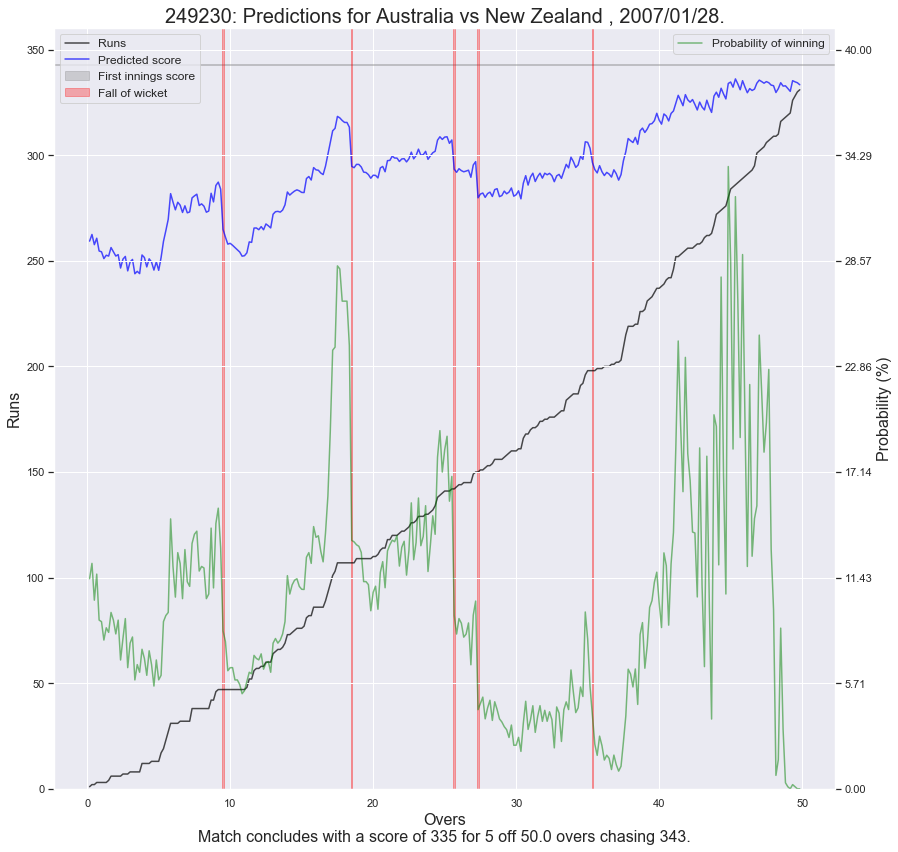

In [12]:
match_id = 249230

teams =  stats.loc[stats['match_id']==match_id].groupby('innings').agg({'batting_team':'first'}).reset_index()
batting_first = teams.loc[teams['innings']==1,'batting_team'][0]
batting_second= teams.loc[teams['innings']==2,'batting_team'][1]
date = match_information.loc[match_information['match_id'] == match_id,'start_date']
date = date.values[0]

MatchPredictions = SecondInningsPredictions.loc[SecondInningsPredictions['match_id'] == match_id]

score = MatchPredictions.iloc[0,:]['score']
target_score = MatchPredictions.iloc[0,:]['target_score']

fig, ax = plt.subplots(1,1, figsize=(14,14))

line1 = sns.lineplot(x='over', y='cum_score', data=MatchPredictions,ax=ax,color='black',alpha=0.7)

line2 = sns.lineplot(x='over', y='pred_score_r', data=MatchPredictions,ax=ax, color='blue',alpha=0.7)

#plot the target score
ax.axhspan(target_score-0.25,target_score+0.25, alpha=0.3, color='grey')


          
last_over = np.floor(MatchPredictions.over.max() + 1/6)
last_ball = ((MatchPredictions.over.max() + 1/6 % 1) - last_over) * 6/10
last = last_over + last_ball
    


#plot the probability of winning
ax2 = ax.twinx()
line3 = sns.lineplot(x='over', y='win_chance_pct', data=MatchPredictions,ax=ax2,color='green',alpha=0.5)

# #plot when wickets are taken
fall_of_wicket = []
fall_of_wicket = MatchPredictions[['wickets','over']].drop_duplicates('wickets',keep='first')
fall_of_wicket = fall_of_wicket.loc[:,'over'].values[1:]
for wicket in fall_of_wicket:
    ax.axvspan(wicket-0.05, wicket+0.05, alpha=0.3, color='red')
if MatchPredictions['wickets'].max() == 9:
    if MatchPredictions['over'].max() < 49 + 5/6:
        if MatchPredictions['cum_score'].max() < target_score:
            last_ball = MatchPredictions['over'].max() + 1/6
            ax.axvspan(last_ball-0.05, last_ball+0.05, alpha=0.3, color='red')
            fall_of_wicket = np.append(fall_of_wicket,last_ball)
            
#caption (text added below x label)
caption = 'Match concludes with a score of {} for {} off {} overs chasing {}.'.format(int(score),len(fall_of_wicket),last,int(target_score))
ax.set_ylim([0,ax.get_ylim()[-1]])


#label axes
ax.set_title('{}: Predictions for {} vs {} , {}.'.format(match_id,batting_first,batting_second,date), fontsize=20)
ax.set_xlabel('Overs' + '\n' + caption, fontsize=16)
ax.set_ylabel('Runs', fontsize=16)
ax.legend(labels=['Runs','Predicted score','First innings score','Fall of wicket'], loc='upper left', fontsize=12)

ax2.legend(labels=['Probability of winning'],loc='upper right', fontsize=12)
ax2.set_ylabel('Probability (%)', fontsize=16)


#scale axes so ticks align
yticks = ax.get_yticks()
ylimits = ax.get_ylim()
yticks = yticks[yticks > ylimits[0]]
yticks = yticks[yticks < ylimits[1]]

scale = ax.get_ylim()[1] / yticks[-1]
ax2.set_yticks(np.linspace(0, ax2.get_yticks()[-1], 1+len(yticks)))
ax2.set_ylim([0,ax2.get_yticks()[-1]*scale])


plt.show()


In [ ]:
### 7.3 Ensemble predictions

In this section I want to validate how well the probability of winning corresponds to actual wins. To do this I will split the data into overs. For a given over (or ball within an over) i will take a sum of the chance of winning and compare this to the number of actual wins. If the predictions are strong then the two numbers should match.

 * note that to evaluate confidence I need to bootstrap the grouping by over number so that I can see how much the two sums vary (ie it may be coincidence that some inaccuracies cancel out)

The largest positive bias is bias_pct    4.983385
dtype: float64% and the largest negative bias isbias_pct   -6.899008
dtype: float64%
The mean absolute bias is bias_pct    1.530468
dtype: float64


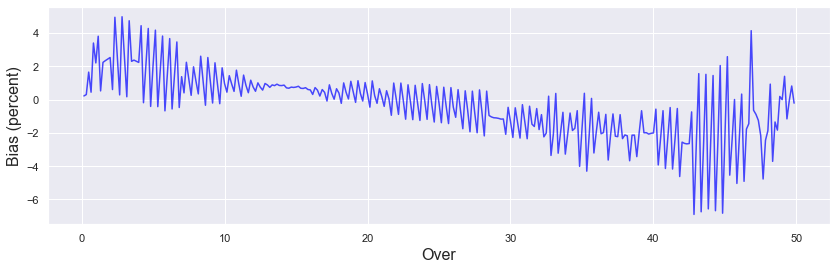

In [13]:
#comparison = SecondInningsPredictions.groupby('over').sum()[['2nd_team_win','win_chance_pct']]
comparison = SecondInningsPredictions.groupby('over').agg({'match_id':'count','2nd_team_win':'sum','win_chance_pct':'sum'})
comparison['win_chance_pct'] = comparison['win_chance_pct'] / 100
comparison.rename(columns={'2nd_team_win':'2nd_team_total_wins','win_chance_pct':'expected_wins','match_id':'total_matches'},inplace=True)
comparison['bias_pct'] = 100*(comparison['2nd_team_total_wins'] - comparison.expected_wins) / comparison.total_matches
comparison.reset_index(inplace=True)

largest_pos_bias = np.max((comparison[['bias_pct']]))
largest_neg_bias = np.min((comparison[['bias_pct']]))
mean_abs_bias = np.mean(np.abs(comparison[['bias_pct']]))

print('The largest positive bias is {}% and the largest negative bias is{}%'.format(largest_pos_bias,largest_neg_bias))
print('The mean absolute bias is {}'.format(mean_abs_bias))

fig, ax = plt.subplots(1,1, figsize=(14,4))
line1 = sns.lineplot(x='over', y='bias_pct', data=comparison,ax=ax,color='blue',alpha=0.7)

ax.set_xlabel('Over', fontsize=16)
ax.set_ylabel('Bias (percent)', fontsize=16)
plt.show()

The ensemble predictions show a slight bias in calculating the winning percentage. It appears that the chasing team (team batting second innings) is slightly overestimated in the first half of the match and slightly underestimated towards the end. The variance appears greater towards the end of the match because the likelihood of winning can vary quickly based on a single wicket or a batsman hitting a six. 

To fully estimate the variance of the data as a whole the process needs to be repeated using bootstrapping to estimate the confidence intervals of the 'winning percent' estimation. 

### 7.4 User defined winning estimation

In this section I write some code which allows for custom predictions to be made. The variables are over_number (using sixths fractions), wickets down, cumulative score, striker runs, offstriker runs.


In [14]:
#Define batting variables

#over number (balls within an over represented as sixths)
over_number = 40 +5/6
wickets = 7
cum_score = 200
strike_runs = 10
offstrike_runs = 10

#set target score

target = 260

#############################################################
#fit model 

N = 2 #fit model around 2 overs
#predictions on score
sc = StandardScaler()
        #train on a window around over_number
X_train_o_ = X_full.loc[np.abs(X_full.over - over_number) <= N]
X_train_o = sc.fit_transform(X_train_o_.to_numpy())
        #test on over number
X_test_o_ = X_full.loc[X_full.over == over_number]
X_test_o = sc.transform(X_test_o_.to_numpy())
    
y_train_ro = y_full_r[np.abs(X_full.over - over_number) <= N]
y_train_ro = y_train_ro.to_numpy().ravel()
    
X_test_o_2_ = X_full_2.loc[X_full_2.over == over_number]
X_test_o_2 = sc.transform(X_test_o_2_.to_numpy())

lin = LinearRegression()
lin.fit(X_train_o,y_train_ro)

X_scaled = sc.transform(np.array([over_number,wickets,cum_score,strike_runs,offstrike_runs]).reshape(1, -1))

pred_rr = lin.predict(X_scaled)[0]
pred_score = pred_rr * (50 - over_number) + cum_score


#
win_chance = win_pct(grouped_errors,target - pred_score, over_number)

print('The predicted second innings score is {:.0f}. The chasing team has a {:.2f}% chance of reaching the target score of {}. Remaining resources {} wickets and {:.2f} overs.'.format(pred_score,win_chance,target,10-wickets,50-over_number))


The predicted second innings score is 248. The chasing team has a 29.72% chance of reaching the target score of 260. Remaining resources 3 wickets and 9.17 overs.


#### Remarks

Consider two scenerios:

1. Chasing total 260, current score 200, wickets 3, strike runs 10, offstrike runs 10
2. Chasing total 260, current score 200, wickets 7, strike runs 10, offstrike runs 10

In the first case the predicted score is 280 and the chances of victory are 82.66%. In the second case the predicted score is 248 and the chances of victory are 29.05%. Note that the only variable that changes between the two scenerios is the number of available wickets. 

In the first scenerio it is unlikly that enough wickets will fall to prevent the second team reaching the total, which can be achieved at a relatively comfortable 6.54 runs per over. Conversely in the second scenerio the team batting second is likely to have poorer batsmen at the crease who cannot score at a high rate. Additionally there is a real chance that the team will be bowled out before the full 50 overs. The chances calculated seem to be intuitively within a range that may be considered reasonable.

Note that these predictions take into account no information from the playing ground or the teams playing. On a pitch where batting conditions are favourable it is likley that the chances of a successful runchace will be underestimated. Similarly if the team is regarded as a strong team playing a weak team their chances may also be underestimated. The converse is also true. 

Incorporting this data would help improve the precision of the predictions. For this project I have not incorporated these considerations for two reasons. The first is that the dataset is limited (batting lineups not provided). The second is that by omitting prior data each estimation is provided purely on the statistics within the match itself (ie. it is performed blindly without bias towards a team or ground). This is similar in application to the Duckworth-Lewis system which is used to determine the winning team in matches which have been shortened due to delays in play.

One improvement that could be made without bias in both this project and in the Duckworth-Lewis system is incorporating what number batsman is at the crease. For example if an opening batsman is at the crease with a lower order batsman the potential scoring power is much higher than if two lower order batsmen are at the crease for the same number of wickets down. This is somewhat incorporated into the model used here through the cumulative runsn scored by striker and offstriker. If a high order batsman is still in play they are likley to have scored a large number of runs by the time many wickets are taken.

### 7.2 Greatest final 10 overs batting comeback

As a short exercise I plot the predictions for the batting team with the lowest chances of winning at the 40 over mark who then went on to win the match.

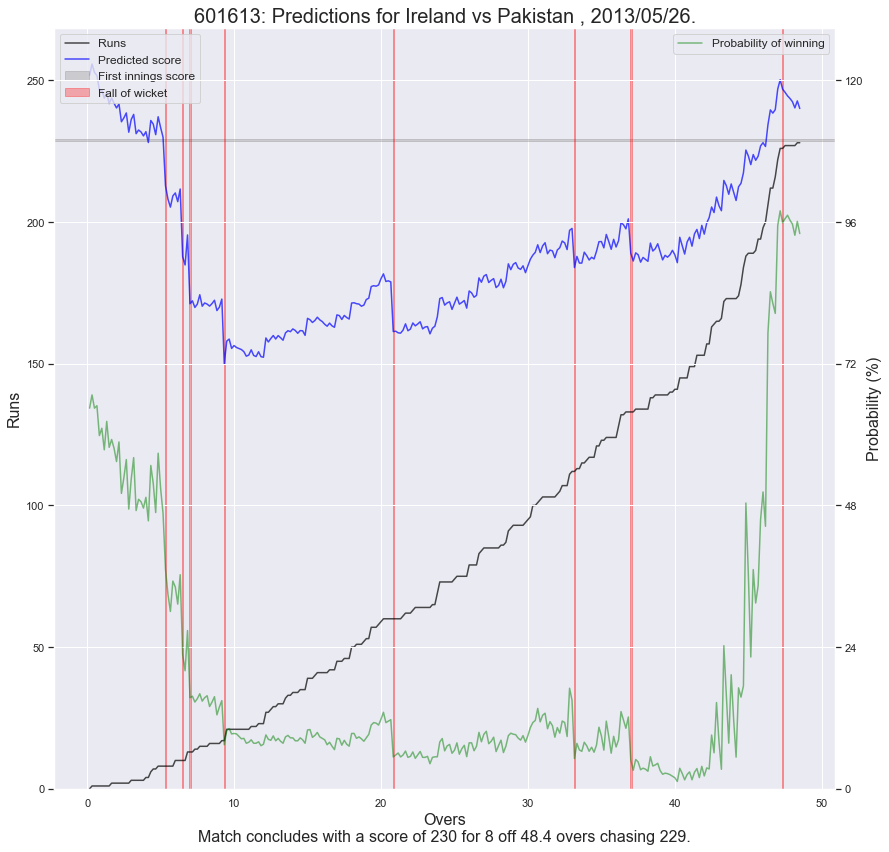

In [15]:
wins_at_40 = SecondInningsPredictions.loc[(SecondInningsPredictions['2nd_team_win']==True) & (SecondInningsPredictions['over']==40)]

biggest_turnaround = wins_at_40.loc[wins_at_40['win_chance_pct'].idxmin(),:]

############usual plotting code

match_id = biggest_turnaround['match_id']

teams =  stats.loc[stats['match_id']==match_id].groupby('innings').agg({'batting_team':'first'}).reset_index()
batting_first = teams.loc[teams['innings']==1,'batting_team'][0]
batting_second= teams.loc[teams['innings']==2,'batting_team'][1]
date = match_information.loc[match_information['match_id'] == match_id,'start_date']
date = date.values[0]

MatchPredictions = SecondInningsPredictions.loc[SecondInningsPredictions['match_id'] == match_id]

score = MatchPredictions.iloc[0,:]['score']
target_score = MatchPredictions.iloc[0,:]['target_score']

fig, ax = plt.subplots(1,1, figsize=(14,14))

line1 = sns.lineplot(x='over', y='cum_score', data=MatchPredictions,ax=ax,color='black',alpha=0.7)

line2 = sns.lineplot(x='over', y='pred_score_r', data=MatchPredictions,ax=ax, color='blue',alpha=0.7)

#plot the target score
ax.axhspan(target_score-0.25,target_score+0.25, alpha=0.3, color='grey')


          
last_over = np.floor(MatchPredictions.over.max() + 1/6)
last_ball = ((MatchPredictions.over.max() + 1/6 % 1) - last_over) * 6/10
last = last_over + last_ball
    


#plot the probability of winning
ax2 = ax.twinx()
line3 = sns.lineplot(x='over', y='win_chance_pct', data=MatchPredictions,ax=ax2,color='green',alpha=0.5)

# #plot when wickets are taken
fall_of_wicket = []
fall_of_wicket = MatchPredictions[['wickets','over']].drop_duplicates('wickets',keep='first')
fall_of_wicket = fall_of_wicket.loc[:,'over'].values[1:]
for wicket in fall_of_wicket:
    ax.axvspan(wicket-0.05, wicket+0.05, alpha=0.3, color='red')
if MatchPredictions['wickets'].max() == 9:
    if MatchPredictions['over'].max() < 49 + 5/6:
        if MatchPredictions['cum_score'].max() < target_score:
            last_ball = MatchPredictions['over'].max() + 1/6
            ax.axvspan(last_ball-0.05, last_ball+0.05, alpha=0.3, color='red')
            fall_of_wicket = np.append(fall_of_wicket,last_ball)

#caption (text added below x label)
caption = 'Match concludes with a score of {} for {} off {} overs chasing {}.'.format(int(score),len(fall_of_wicket),last,int(target_score))
ax.set_ylim([0,ax.get_ylim()[-1]])

#label axes
ax.set_title('{}: Predictions for {} vs {} , {}.'.format(match_id,batting_first,batting_second,date), fontsize=20)
ax.set_xlabel('Overs' + '\n' + caption, fontsize=16)
ax.set_ylabel('Runs', fontsize=16)
ax.legend(labels=['Runs','Predicted score','First innings score','Fall of wicket'], loc='upper left', fontsize=12)

ax2.legend(labels=['Probability of winning'],loc='upper right', fontsize=12)
ax2.set_ylabel('Probability (%)', fontsize=16)


#scale axes so ticks align
yticks = ax.get_yticks()
ylimits = ax.get_ylim()
yticks = yticks[yticks > ylimits[0]]
yticks = yticks[yticks < ylimits[1]]

scale = ax.get_ylim()[1] / yticks[-1]
ax2.set_yticks(np.linspace(0, ax2.get_yticks()[-1], 1+len(yticks)))
ax2.set_ylim([0,ax2.get_yticks()[-1]*scale])


plt.show()

#### remarks

The largest batting turnaround appears to occur between Pakistan and Ireland in 2013. With 60 balls left in the match Pakistan was 7 wickets down on 141 runs chasing a total of 229. Pakistan was estimated to have only a 2.54% chance of winning.

The team managed to reach the required score with 8 balls and 2 wickets to spare. The last 88 runs came at a runrate of 10.15. 

### 7.3 Greatest final 10 overs bolwing comeback

As a final short excercise I plot the predictions for the bowling team with the lowest chances of winning at the 40 over mark who then went on to win the match.

match_id           649091
over                   40
score                 182
wickets                 4
cum_score             159
pred_r            7.32438
pred_score_r      232.244
target_score          183
2nd_team_win        False
win_chance_pct    98.4848
Name: 194223, dtype: object

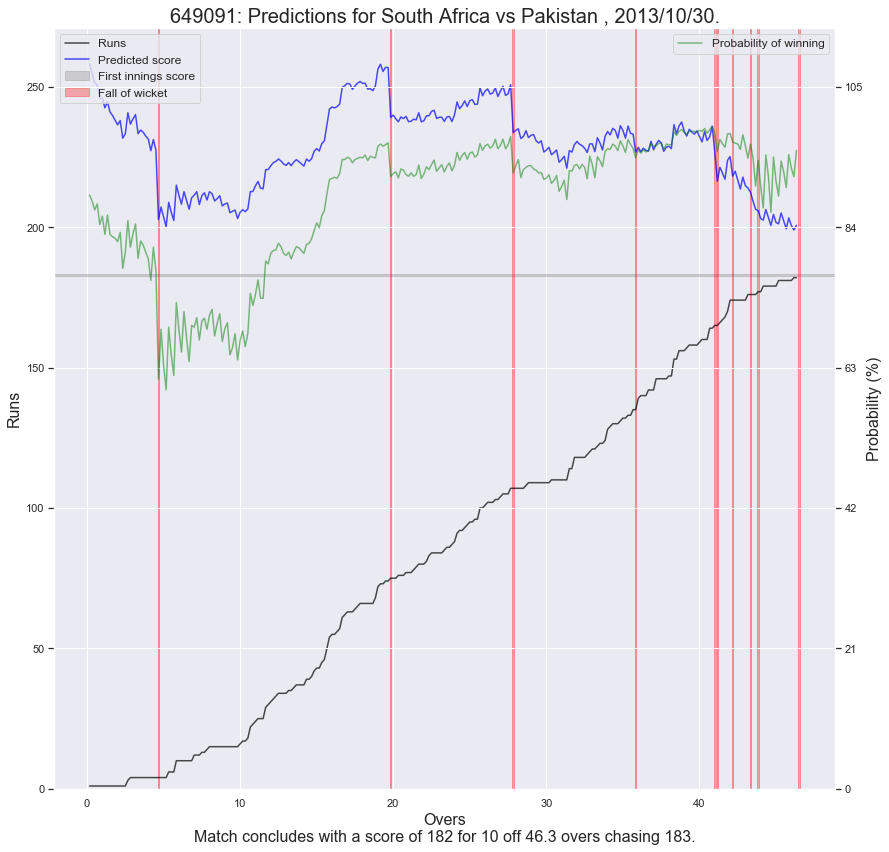

In [16]:
losses_at_40 = SecondInningsPredictions.loc[(SecondInningsPredictions['2nd_team_win']==False) & (SecondInningsPredictions['over']==40)]

biggest_turnaround = losses_at_40.loc[losses_at_40['win_chance_pct'].idxmax(),:]

display(biggest_turnaround)
############usual plotting code

match_id = biggest_turnaround['match_id']

teams =  stats.loc[stats['match_id']==match_id].groupby('innings').agg({'batting_team':'first'}).reset_index()
batting_first = teams.loc[teams['innings']==1,'batting_team'][0]
batting_second= teams.loc[teams['innings']==2,'batting_team'][1]
date = match_information.loc[match_information['match_id'] == match_id,'start_date']
date = date.values[0]

MatchPredictions = SecondInningsPredictions.loc[SecondInningsPredictions['match_id'] == match_id]

score = MatchPredictions.iloc[0,:]['score']
target_score = MatchPredictions.iloc[0,:]['target_score']

fig, ax = plt.subplots(1,1, figsize=(14,14))

line1 = sns.lineplot(x='over', y='cum_score', data=MatchPredictions,ax=ax,color='black',alpha=0.7)

line2 = sns.lineplot(x='over', y='pred_score_r', data=MatchPredictions,ax=ax, color='blue',alpha=0.7)

#plot the target score
ax.axhspan(target_score-0.25,target_score+0.25, alpha=0.3, color='grey')


          
last_over = np.floor(MatchPredictions.over.max() + 1/6)
last_ball = ((MatchPredictions.over.max() + 1/6 % 1) - last_over) * 6/10
last = last_over + last_ball
    


#plot the probability of winning
ax2 = ax.twinx()
line3 = sns.lineplot(x='over', y='win_chance_pct', data=MatchPredictions,ax=ax2,color='green',alpha=0.5)

# #plot when wickets are taken
fall_of_wicket = []
fall_of_wicket = MatchPredictions[['wickets','over']].drop_duplicates('wickets',keep='first')
fall_of_wicket = fall_of_wicket.loc[:,'over'].values[1:]
for wicket in fall_of_wicket:
    ax.axvspan(wicket-0.05, wicket+0.05, alpha=0.3, color='red')
if MatchPredictions['wickets'].max() == 9:
    if MatchPredictions['over'].max() < 49 + 5/6:
        if MatchPredictions['cum_score'].max() < target_score:
            last_ball = MatchPredictions['over'].max() + 1/6
            ax.axvspan(last_ball-0.05, last_ball+0.05, alpha=0.3, color='red')
            fall_of_wicket = np.append(fall_of_wicket,last_ball)

#caption (text added below x label)
caption = 'Match concludes with a score of {} for {} off {} overs chasing {}.'.format(int(score),len(fall_of_wicket),last,int(target_score))
ax.set_ylim([0,ax.get_ylim()[-1]])

#label axes
ax.set_title('{}: Predictions for {} vs {} , {}.'.format(match_id,batting_first,batting_second,date), fontsize=20)
ax.set_xlabel('Overs' + '\n' + caption, fontsize=16)
ax.set_ylabel('Runs', fontsize=16)
ax.legend(labels=['Runs','Predicted score','First innings score','Fall of wicket'], loc='upper left', fontsize=12)

ax2.legend(labels=['Probability of winning'],loc='upper right', fontsize=12)
ax2.set_ylabel('Probability (%)', fontsize=16)


#scale axes so ticks align
yticks = ax.get_yticks()
ylimits = ax.get_ylim()
yticks = yticks[yticks > ylimits[0]]
yticks = yticks[yticks < ylimits[1]]

scale = ax.get_ylim()[1] / yticks[-1]
ax2.set_yticks(np.linspace(0, ax2.get_yticks()[-1], 1+len(yticks)))
ax2.set_ylim([0,ax2.get_yticks()[-1]*scale])


plt.show()

In [ ]:
#### Remarks 

The largest batting turnaround appears to occur between South Africa and Pakistan in 2013. With 60 balls left in the match Pakistan was 4 wickets down on 159 runs chasing a total of 183. Pakistan was estimated to have only a 98.48% chance of winning.

South Africa proceeded to bowl out Pakistan, restricting them to 182 runs - one short of the total. The final 6 wickets came for a meer 23 runs.

It is a remarkable coincidence that the best and worst final 10 overs (in terms of batting) both came from Pakistan in 2013, 5 months apart.